In [2]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torch, torchvision


img = Image.open('data_segmentation/oil/Oil_0002.jpg')

img = torchvision.transforms.ToTensor()(img)

# plt.imshow(img.permute(1,2,0))

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                torchvision.transforms.ToTensor()])

dataset = ImageFolder(root='data_segmentation',transform=transform)


train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])

print(len(train_dataset))
print(len(test_dataset))


train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=16, # how many samples per batch?
                              num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=16, 
                             num_workers=0, 
                             shuffle=False) # don't usually need to shuffle testing data


960
240


In [4]:
dataset.classes

['oil', 'scratch', 'stain']

# Model Training

In [54]:
cnn_model = torchvision.models.mobilenet_v2(pretrained=True) #https://pytorch.org/vision/0.8/models.html

for param in cnn_model.parameters():
    param.requires_grad = False


cnn_model.classifier[1] = torch.nn.Linear(in_features= cnn_model.classifier[1].in_features,
                                          out_features=len(dataset.classes))
# cnn_model
# import torchinfo
# torchinfo.summary(cnn_model)

In [65]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn_model.parameters(), lr = 0.001)

import torchmetrics
accuracy_score = torchmetrics.Accuracy(task='multiclass', num_classes=len(dataset.classes)).to('cuda')

In [70]:
from tqdm.auto import tqdm

# Training Loop

cnn_model.to('cuda')

for epoch in tqdm(range(10)):

    running_train_loss = []
    for x_train,y_train in train_dataloader:
        x_train = x_train.to('cuda')
        y_train = y_train.to('cuda')
    
        cnn_model.train() # Kinda important

        y_pred = cnn_model(x_train)

        loss = loss_fn(y_pred,y_train)
        running_train_loss.append(loss.item())

        optimizer.zero_grad() # Kinda important

        loss.backward()

        optimizer.step()


    if epoch % 2 ==0:

        cnn_model.eval()

        running_test_loss = []
        test_accuracy = []

        for x_test,y_test in test_dataloader:
            x_test,y_test  = x_test.to('cuda'),y_test.to('cuda')

            with torch.no_grad():
                test_pred = cnn_model(x_test)
                
            running_test_loss.append(loss_fn(test_pred, y_test).item()) 
            test_accuracy.append(accuracy_score(test_pred.softmax(dim=-1), y_test))

        print(f' train_loss: {sum(running_train_loss)/len(running_train_loss)} || test loss: {sum(running_test_loss)/len(running_test_loss)} || test acc: {sum(test_accuracy)/len(test_accuracy)} ')



  0%|          | 0/10 [00:00<?, ?it/s]

 train_loss: 0.602726956208547 || test loss: 0.3002438028653463 || test acc: 0.9416667222976685 
 train_loss: 0.21934061627835036 || test loss: 0.12203000287214914 || test acc: 0.9750000238418579 
 train_loss: 0.17630138518288732 || test loss: 0.08668181300163269 || test acc: 0.9916667342185974 
 train_loss: 0.14420034748812516 || test loss: 0.06552391946315765 || test acc: 0.9916667342185974 
 train_loss: 0.1293756046021978 || test loss: 0.05885098824898402 || test acc: 0.98333340883255 


# Saving the trained model in pytorch

In [73]:
torch.save(cnn_model.state_dict(), 'cnn_model_1.pth')
# cnn_model = torch.load('cnn_model_1.pth').to('cuda')

In [5]:
weights = torchvision.models.MobileNet_V2_Weights
cnn_model = torchvision.models.mobilenet_v2(weights = weights.DEFAULT)  #https://pytorch.org/vision/0.8/models.html

for param in cnn_model.parameters():
    param.requires_grad = False


cnn_model.classifier[1] = torch.nn.Linear(in_features= cnn_model.classifier[1].in_features,
                                          out_features=len(dataset.classes))

ww = torch.load('cnn_model_1.pth')
cnn_model.load_state_dict(ww)

cnn_model.to('cuda')
cnn_model.eval()




c:\Users\Asus\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Asus\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Visualizing the results

In [81]:
for x_test,y_test in test_dataloader:
    x_test,y_test = x_test.to('cuda'),y_test.to('cuda')

    with torch.no_grad():
        y_pred = cnn_model(x_test)

    break
    

In [23]:
from infer import predict_screen_defect

In [24]:
l,c = predict_screen_defect(r'data_segmentation\oil\Oil_0374.jpg')

In [25]:
l,c

('oil', 0.9840223789215088)

In [95]:

true_classes = [dataset.classes[yl] for yl in y_test]
predicted_classes = [dataset.classes[yl] for yl in y_pred.argmax(dim=1)]
confidence = [yl.max().item() for yl in y_pred.softmax(dim=1)]

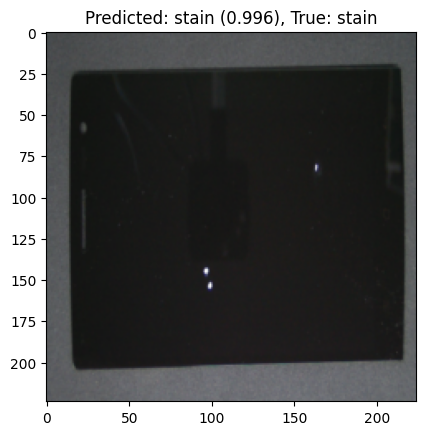

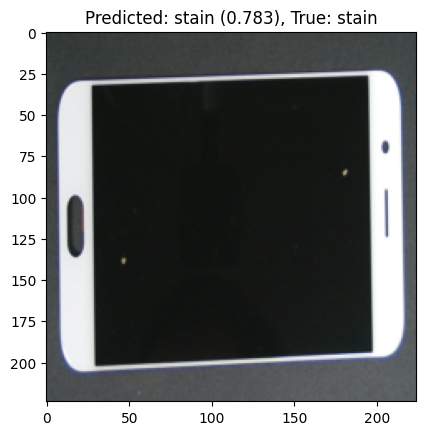

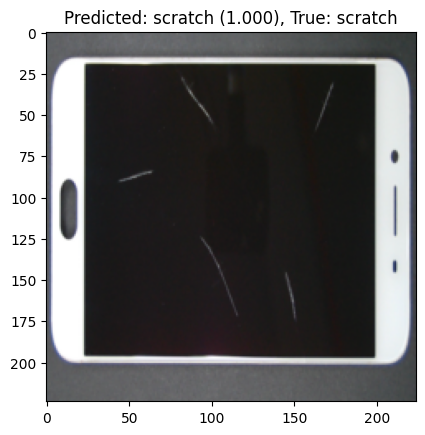

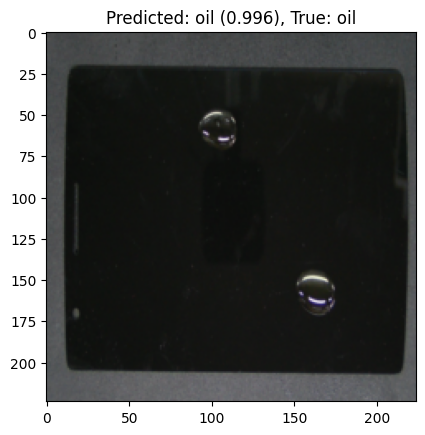

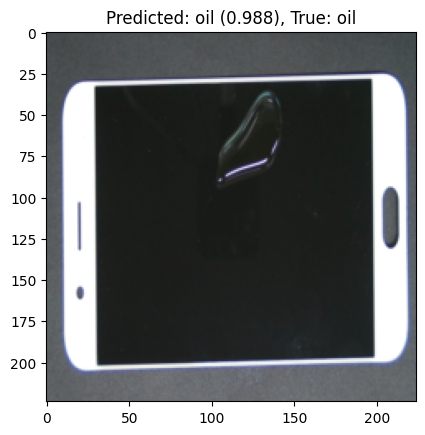

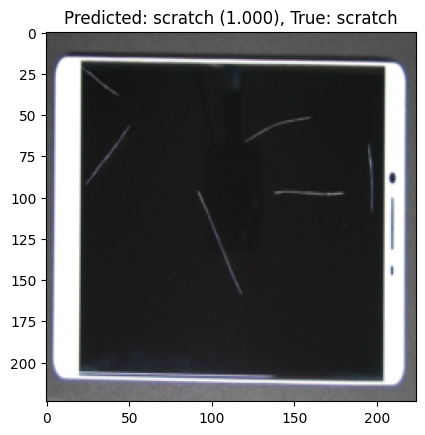

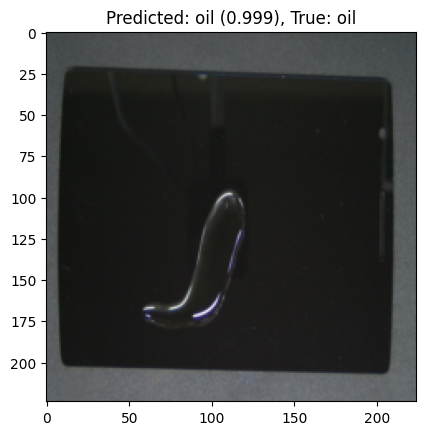

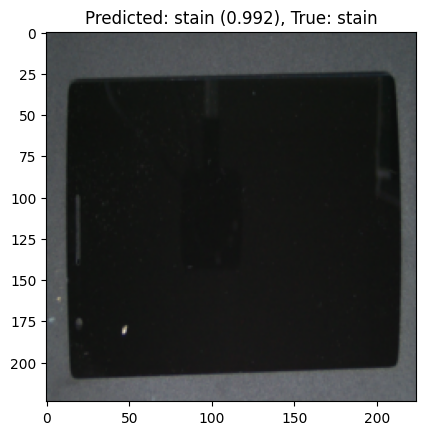

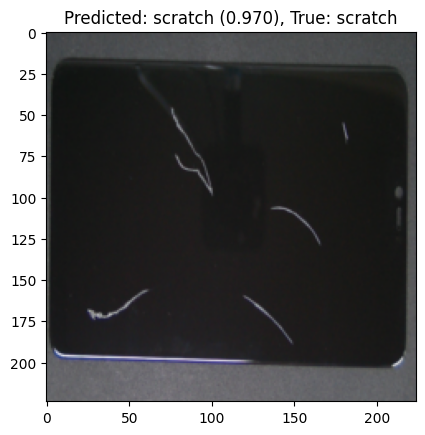

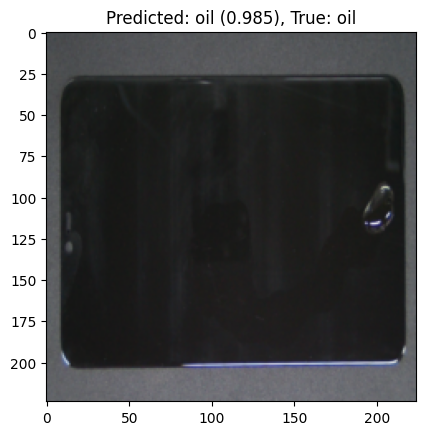

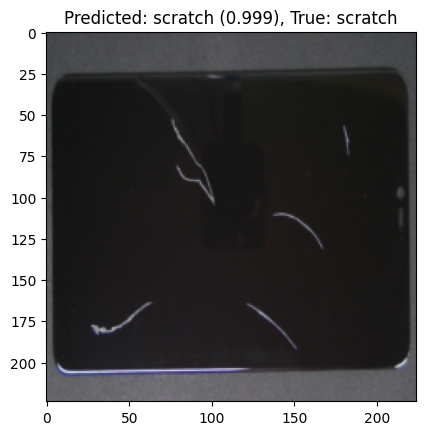

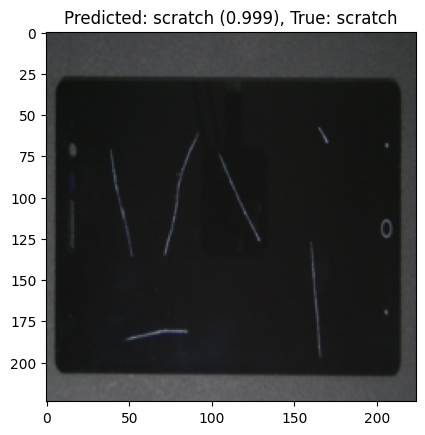

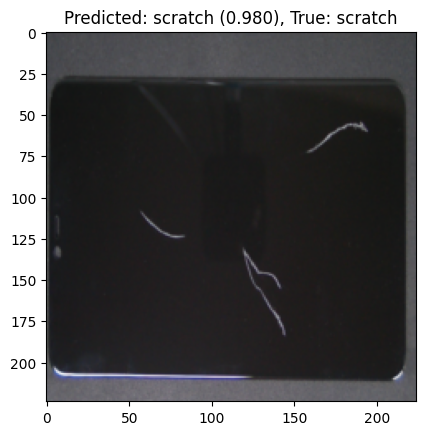

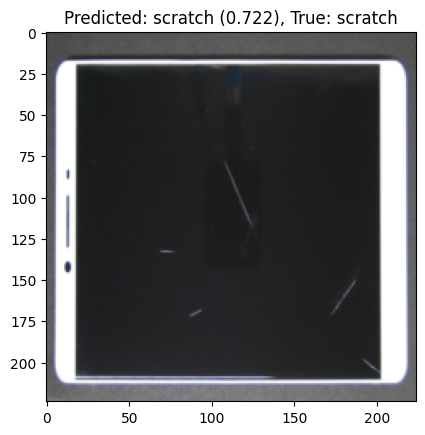

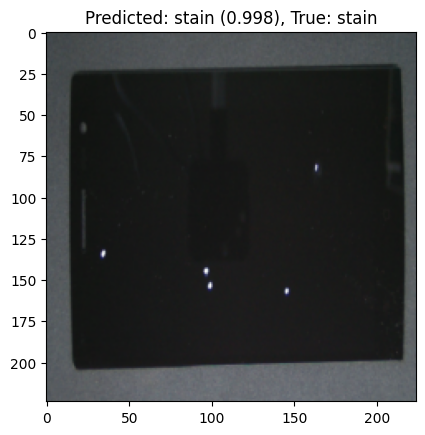

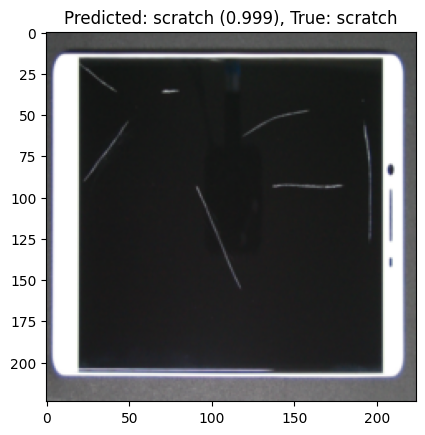

In [97]:
for idx,xx in enumerate(x_test):
    plt.imshow(xx.permute(1,2,0).cpu())
    plt.title(f'Predicted: {predicted_classes[idx]} ({confidence[idx]:.3f}), True: {true_classes[idx]}')
    plt.show()